In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate();
# Pkg.add("ForwardDiff")
# Pkg.add("RobotDynamics")
# Pkg.add("LinearAlgebra")
# Pkg.add("StaticArrays")
# Pkg.add("SparseArrays")
# Pkg.add("Plots")
# Pkg.add("Printf")
# Pkg.add("Ipopt")
# Pkg.add("MathOptInterface")
# Pkg.add("TrajOptPlots")
using ForwardDiff
using Test
using RobotDynamics
using LinearAlgebra
using StaticArrays
using SparseArrays
using Plots
using Ipopt
using MathOptInterface
using TrajOptPlots
const MOI = MathOptInterface

# using PyPlots
using Printf

# include("quadratic_cost.jl")


 Activating environment at `~/Desktop/Home/CMU/2021 Courses/16745 OC/Project.toml`


# Final Project Info
In this we present a geostationary transfer orbit to a geosynchronous (GSO) or geostationary orbit (GEO).  We use Keplerian Orbital Dynamics to model our system. We make several assumptions like Earth Reference Frame, Spherical Earth, Kepler Dynamics. 

## The Model
We'll be using the Kepler Dynamics:

$\newcommand{\norm}[1]{\left\lVert#1\right\rVert}$

$$ 
\ddot{r} = F = \frac{-\mu}{\norm{r}^3}*r+u \\
x = [r, \dot{r}] \\
\norm{u} \le Tmax
$$
with the following model parameters:
* $\mu$: Gravitational Parameter = 63781
* $r$: distance to earth center
* $u$: control of ion thruster

In [2]:
# Problem Setup
# Dont want KM and S
# Rescale unite to order 1
# Length unit = SMA 
# Time scale = T orbit period
# Helps condition number 

Nx = 6 
Nu = 3

# TODO Rescale μ 
# Hint can take big steps 10 knot points per-orbit
# model = Kepler() # TODO
# n,m = size(model)          # state and control dimensions
dt = 0.025                 # time step (sec)
tf = 1.5                   # time horizon (sec)
T = Int(tf/dt) + 1         # number of time steps

n_nlp = (Nx+Nu)*T # number of decision variables
m_nlp = Nx*(T+1)

# Initial & final condition

#cartesian and ECI
#x,y,z,vx,vy,vz
earthRadius_km = 6378.1 # [km]
LEO_km = 500 #km above sealevel #circular low earth orbit # 250km 
GSO_km = 35786 #km above sealevel #circular geosychonous orbit
μ_km_s = 3.986*10e5 #gravitational0 parameter [km^3 / s^2]
semiMajorAxis_scale = (GSO_km+earthRadius_km+earthRadius_km+LEO_km)/2
period_scale = sqrt(semiMajorAxis_scale^3/μ_km_s)*2*pi
μ = μ_km_s*period_scale^2/semiMajorAxis_scale^3  #μ(OU^3/P^2)

struct Orbit{T}
    semiMajorAxis::T
    period::T
    perigee::T #closest radius to earth
    perigee_V::T #velocity at perigee
    x0::Vector{T}
#     function Orbit(x0) 
#         print(x0) #best is to input point with velocity and calucate useful parts of orbit
#     end
end

function make_orbit(x0)
    velocity = norm(x0[4:end])
    
    radius = norm(x0[1:3])
    
    semiMajorAxis = 1/(-velocity^2/μ+2/radius)  #reverse vis a viv
    
    period = sqrt(semiMajorAxis^3/μ)*2*pi       #period equation
    
    E = velocity^2/2 - μ/radius   #specific energy of satellite
    
    J = norm(cross(x0[1:3],x0[4:end]))           #specific momentum of satellite
    
    perigee = -μ/(2*E) - 1/2*sqrt(μ^2/(E^2)+2*J^2/E) #solve quadratic when velocity of radius is 0
    
    perigee_v =  sqrt(μ*(2.0/perigee-1.0/semiMajorAxis)) # Vis a Viv
    apogee  = -μ/(2*E) + 1/2(μ^2/(E^2)+2*J^2/E) #solve quadratic when velocity of radius is 0
    apogee_v =  sqrt(μ*(2.0/apogee-1.0/semiMajorAxis)) # Vis a Viv
    return Orbit(semiMajorAxis, period, perigee, perigee_v, x0)
end

make_orbit (generic function with 1 method)

In [3]:
# Geosynchronous Transfer orbit (starting position)
semiMajorAxis_transfer = (GSO_km+earthRadius_km+earthRadius_km+LEO_km)/(2*semiMajorAxis_scale) #OU
instantRadius_transfer = (earthRadius_km+LEO_km) / semiMajorAxis_scale # #OU
instantVelocity_transfer = sqrt(μ*(2.0/instantRadius_transfer-1.0/semiMajorAxis_transfer)) #sqrt(OU^3/P^2/OU) =OU/P
period_transfer = sqrt(semiMajorAxis_transfer^3/μ)*2*pi
x0    = [instantRadius_transfer, 0.0, 0.0, 0.0, instantVelocity_transfer, 0.0] # initial state #geosynchronous transfer orbit (GTO, where rocket dropped satellite off)
                                                                             #many kilometers above Africa in an elliptical orbit 
transfer_orbit = Orbit(semiMajorAxis_transfer, period_transfer, instantRadius_transfer, instantVelocity_transfer, x0)

Orbit{Float64}(1.0, 1.0, 0.28049720444841386, 15.556684458046954, [0.28049720444841386, 0.0, 0.0, 0.0, 15.556684458046954, 0.0])

In [4]:
# Geosynchronous Orbit (goal position)
semiMajorAxis_goal = 2*(earthRadius_km+GSO_km)/(2*semiMajorAxis_scale)
instantRadius_goal = (earthRadius_km+GSO_km) / semiMajorAxis_scale
instantVelocity_goal = sqrt(μ*(2.0/instantRadius_goal-1.0/semiMajorAxis_goal)) # VisViva
period_goal = sqrt(semiMajorAxis_goal^3/μ)*2*pi
xgoal = [instantRadius_goal, 0.0, 0.0, 0.0, instantVelocity_goal, 0.0] # goal state #circular geosychonous orbit above africa
goal_orbit = Orbit(semiMajorAxis_goal, period_goal, instantRadius_goal, instantVelocity_goal, xgoal)
ugto = zeros(3)                  # hover controls

# Cost matrices
# Q = #TODO  #Diagonal(SVector{6}([ones(3) ; fill(0.1, 3)]))
# R = #TODO  #Diagonal(@SVector fill(1e-2, m))
# Qf = #TODO #Diagonal(@SVector fill(1e2, n));

In [5]:
function cost(Z)
    X = Z[1:Nx, :]
    U = Z[Nx+1:Nx+Nu, :]
    N = length(Z)
    J = 0.0
    for k = 1:N-1
        J += norm(U[k])^2 + (norm(X[k])-norm(goal_orbit.perigee))
    end 
    J += (norm(X[end])-norm(x_goal))
    return J 
end

cost (generic function with 1 method)

## Dynamics

In [6]:
function dynamics(x, u)
    # x = state [x, y, z, dx, dy, dz]
    # u = control [ux, uy, uz]
    r = x[1:3] #orbital units (OU)
    ṙ = x[4:end] #
    r̈ = (-μ/(norm(r)^3))*r + u #μ(OU^3/P^2)/OU^3*OU
    return [ṙ; r̈]
end

dynamics (generic function with 1 method)

In [7]:
function integrator!(x, u, h)
    # x = state
    # u = control
    # h = time step
#     ẋ = dynamics(x, u)
    f1 = dynamics(x, u)
    f2 = dynamics(x + 0.5*h*f1, u)
    f3 = dynamics(x + 0.5*h*f2, u)
    f4 = dynamics(x + h*f3, u)
    x .+= (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
end

integrator! (generic function with 1 method)

In [8]:
function dynamics_rk4(x, u, h)
    # x = state
    # u = control
    # h = time step
#     ẋ = dynamics(x, u)
    f1 = dynamics(x, u)
    f2 = dynamics(x + 0.5*h*f1, u)
    f3 = dynamics(x + 0.5*h*f2, u)
    f4 = dynamics(x + h*f3, u)
    return (x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4))
end

dynamics_rk4 (generic function with 1 method)

In [9]:
function get_energy(x)
    return norm(x[4:end])^2/2 - μ/norm(x[1:3])
end

get_energy (generic function with 1 method)

In [10]:
function plot_orbit(orbit::Orbit)
    knots = 1000
    t = range(0, orbit.period, length=knots) 
    h = t[2]-t[1]
    traj = zeros(size(t)[1], size(x0)[1])
    x = copy(orbit.x0)
    traj[1,:] .= x
    
    u = zeros(3)
    energy = zero(t)
    energy[1] = get_energy(x)
    for i in 2:size(t)[1]
        integrator!(x, u, h)
        traj[i,:] .= x
        energy[i] = get_energy(x)
        orbit = make_orbit(x)
    end
#     plot(t, energy)
    plot(traj[:, 1], traj[:, 2], aspect_ratio=:equal, lims=(-semiMajorAxis_goal*1.5,semiMajorAxis_goal*1.5))
end

plot_orbit (generic function with 1 method)

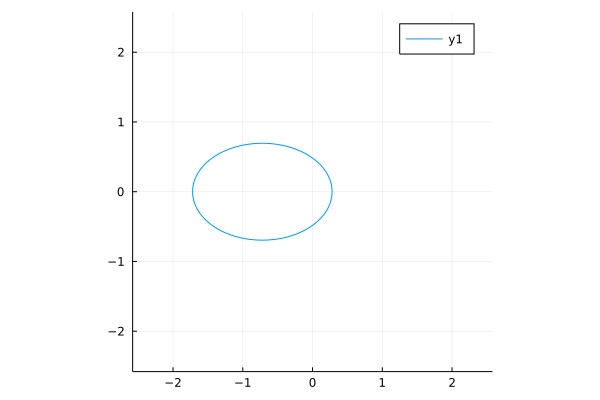

In [11]:
# plot(t, energy)
plot_orbit(transfer_orbit)

## Constraints

$ c = [c_{init}, c_{terminal}, c_{dynamics}, c_{thurst}] $

In [67]:
# Lots of weird Hard codes to fix! 

n = 6
m = 3

Base.@kwdef struct SimpleOrbit <: AbstractModel
    g::Float64 = 9.81
    mb::Float64 = 5.0
    mf::Float64 = 1.0
    ℓ_min::Float64 = 0.5
    ℓ_max::Float64 = 1.5
end
RobotDynamics.state_dim(::SimpleOrbit) = 6
RobotDynamics.control_dim(::SimpleOrbit) = 3


struct OrbitNLP{n,m,L,Q} <: MOI.AbstractNLPEvaluator
    model::L                                 # dynamics model
#     obj::Vector{QuadraticCost{n,m,Float64}}  # objective function
    N::Int                                   # number of knot points
    M::Int                                   # number of steps in each mode
    tf::Float64                              # total time (sec)
    x0::MVector{n,Float64}                   # initial condition
    xf::MVector{n,Float64}                   # final condition
    times::Vector{Float64}                   # vector of times
    xinds::Vector{SVector{n,Int}}            # Z[xinds[k]] gives states for time step k
    uinds::Vector{SVector{m,Int}}            # Z[uinds[k]] gives controls for time step k
    cinds::Vector{UnitRange{Int}}            # indices for each of the constraints
    lb::Vector{Float64}                      # lower bounds on the constraints
    ub::Vector{Float64}                      # upper bounds on the constraints
    zL::Vector{Float64}                      # lower bounds on the primal variables
    zU::Vector{Float64}                      # upper bounds on the primal variables
    rows::Vector{Int}                        # rows for Jacobian sparsity
    cols::Vector{Int}                        # columns for Jacobian sparsity
    function OrbitNLP(model,
            tf::Real, N::Integer, M::Integer, x0::AbstractVector, xf::AbstractVector, integration::Type{<:QuadratureRule}=RK4
        ) #where {n,m}
        # Create indices
        xinds = [SVector{n}((k-1)*(n+m) .+ (1:n)) for k = 1:N]
        uinds = [SVector{m}((k-1)*(n+m) .+ (n+1:n+m)) for k = 1:N-1]
        times = collect(range(0, tf, length=N))
        
        # TODO: specify the constraint indices
        c_init_inds = 1:n
        c_term_inds = (c_init_inds[end]+1):(c_init_inds[end]+n)
        c_dyn_inds = (c_term_inds[end]+1):(c_term_inds[end]+(n*(N-1)))
        c_thrust_inds = c_dyn_inds[end]+1:c_dyn_inds[end]+((N-1))
        
        # TODO: specify the bounds on the constraints
         m_nlp = c_thrust_inds[end]
        lb = zeros(m_nlp) 
        lb[c_init_inds] .= 0 ##x0
        lb[c_term_inds] .= 0 #xf
        lb[c_dyn_inds] .= 0
        lb[c_thrust_inds] .= -Inf

        ub = zeros(m_nlp) #fill(-Inf,m_nlp)
        ub[c_init_inds] .= 0 #x0
        ub[c_term_inds] .= 0 #xf
        ub[c_dyn_inds] .= 0
        ub[c_thrust_inds] .= Inf
        
        # Other initialization
        cinds = [c_init_inds, c_term_inds, c_dyn_inds, c_thrust_inds]
        n_nlp = n*N + (N-1)*m
        zL = fill(-Inf, n_nlp)
        zU = fill(+Inf, n_nlp)
        rows = Int[]
        cols = Int[]
        
        new{n,m,typeof(model), integration}(
            model,
            N, M, tf, x0, xf, times,
            xinds, uinds, cinds, lb, ub, zL, zU, rows, cols
        )
    end
end
Base.size(nlp::OrbitNLP{n,m}) where {n,m} = (n,m,nlp.N)
num_primals(nlp::OrbitNLP{n,m}) where {n,m} = n*nlp.N + m*(nlp.N-1)
num_duals(nlp::OrbitNLP) = nlp.cinds[end][end]

"""
    packZ(nlp, X, U)

Take a vector state vectors `X` and controls `U` and stack them into a single vector Z.
"""
function packZ(nlp, X, U)
    Z = zeros(num_primals(nlp))
    for k = 1:nlp.N-1
        Z[nlp.xinds[k]] = X[k]
        Z[nlp.uinds[k]] = U[k]
    end
    Z[nlp.xinds[end]] = X[end]
    return Z
end

"""
    unpackZ(nlp, Z)

Take a vector of all the states and controls and return a vector of state vectors `X` and
controls `U`.
"""
function unpackZ(nlp, Z)
    X = [Z[xi] for xi in nlp.xinds]
    U = [Z[ui] for ui in nlp.uinds]
    return X, U
end

function TrajOptPlots.visualize!(vis, nlp::OrbitNLP, Z)
    TrajOptPlots.visualize!(vis, nlp.model, nlp.tf, unpackZ(nlp, Z)[1])
end

include("moi.jl") # includes the interface to Ipopt

solve

In [68]:
# function init_constraints()
#     N = T
#     c_init_inds = 1:n
#     c_term_inds = (c_init_inds[end]+1):(c_init_inds[end]+n)
#     c_dyn_inds = (c_term_inds[end]+1):(c_term_inds[end]+(n*(N-1)))
#     c_thrust_inds = c_dyn_inds[end]+1:c_dyn_inds[end]+((N-1))
    
#     m_nlp = c_length_inds[end]
#     lb = zeros(m_nlp) 
#     lb[c_init_inds] .= 0 ##x0
#     lb[c_term_inds] .= 0 #xf
#     lb[c_dyn_inds] .= 0
#     lb[c_thrust_inds] .= -Inf

#     ub = zeros(m_nlp) #fill(-Inf,m_nlp)
#     ub[c_init_inds] .= 0 #x0
#     ub[c_term_inds] .= 0 #xf
#     ub[c_dyn_inds] .= 0
#     ub[c_thrust_inds] .= Inf

#     # Other initialization
#     cinds = [c_init_inds, c_term_inds, c_dyn_inds, c_thrust_inds]
#     n_nlp = n*N + (N-1)*m
    
#     return cinds, lb, ub, m_nlp, n_nlp
# end

In [69]:
# function unpackZ(ztraj)
#     """
#     Inputs: 
#         ztraj -> Trajectory
    
#     Returns: 
#         xtraj -> state trajectory (Nx, T)
#         utraj -> control trajectory (Nu, T-1)
#     """
#     Nt = T
#     z = reshape(ztraj[1:(end-Nx)],Nx+Nu,Nt-1)
#     xtraj = [z[1:Nx,:] ztraj[end-(Nx-1):end]]
#     utraj = z[(Nx+1):(Nx+Nu),:]
    
#     return xtraj, utraj
# end

In [83]:
function dynamics_constraints!(nlp, c, ztraj)
    """
    Inputs: 
        c -> Constraint Vector: shape = 
        ztraj -> Current trajectory: shape ((Nx+Nu)*T, 1)
    
    Returns: 
        Nothing
    """
    h = 1e-3
    X, U = unpackZ(nlp, ztraj)
    N = nlp.N

    d = reshape(view(c, nlp.cinds[3]),n,(N-1))
    
    for k = 1:N-1
        d[:, k] = dynamics_rk4(X[k], U[k], h) - X[k+1]
    end
    
    return d
end
    

dynamics_constraints! (generic function with 1 method)

In [90]:
function thrust_constraints!(nlp, c, ztraj)
    """
    Inputs: 
        c -> Constraint Vector: shape = 
        ztraj -> Current trajectory: shape ((Nx+Nu)*T, 1)
    
    Returns: 
        Nothing
    """
    d = view(c, nlp.cinds[end])
    N = nlp.N
    X, U = unpackZ(nlp, ztraj)
    
    for k = 1:N-1
        d[k] = norm(U[k])
    end
    
    return d
end

thrust_constraints! (generic function with 1 method)

In [91]:
function con!(nlp::OrbitNLP, c, Z)
    X, U = unpackZ(Z)
    c[cinds[1]] .= X[1] - nlp.x0 # Initial condition constraint
    c[cinds[2]] .= X[end] - nlp.xf # Final condition constraint
    dynamics_constraints!(nlp, c, Z) # Dynamics constraints
    thrust_constraints!(nlp, c, Z) # Thrust constraints
end

con! (generic function with 2 methods)

In [92]:
# Define the NLP
model = SimpleOrbit()
nlp = OrbitNLP(model, transfer_orbit.period, 100, 0, x0, xgoal);

@testset "Part c: Constraints" begin
    Z = rand(num_primals(nlp))
    X,U = unpackZ(nlp, Z)
    c = zeros(num_duals(nlp))
    n,m,N = size(nlp)

    @testset "Dynamics constraints" begin
        d = dynamics_constraints!(nlp, c, Z)
        display(d)
        @test length(d) == n*(N-1)
        
#         @test d[1:n] ≈ stance1_dynamics_rk4(model, X[1], U[1], dt) - X[2]
#         @test d[n*(M-1) .+ (1:n)] ≈ jump2_map(stance1_dynamics_rk4(model, X[M], U[M], dt)) - X[M+1]
#         @test d[n*M .+ (1:n)] ≈ stance2_dynamics_rk4(model, X[M+1], U[M+1], dt) - X[M+2]
    end

    @testset "Thrust constraints" begin
        d = thrust_constraints!(nlp, c, Z)
        display(d)
        @test length(d) == N-1
#         @test d[1:M] ≈ [x[4] for x in X[1:M]]
#         @test d[M .+ (1:M)] ≈ [x[6] for x in X[M .+ (1:M)]]
    end

#     @testset "Length constraints" begin
#         d = length_constraint!(nlp, c, Z)
#         @test length(d) == 2N
#         @test d[1] ≈ norm(X[1][1:2] - X[1][3:4])
#         @test d[2] ≈ norm(X[1][1:2] - X[1][5:6])
#         @test d[3] ≈ norm(X[2][1:2] - X[2][3:4])
#         @test d[4] ≈ norm(X[2][1:2] - X[2][5:6])
#     end
end;

6×99 reshape(view(::Array{Float64,1}, 13:606), 6, 99) with eltype Float64:
 -0.577342    0.65664    -0.631539   …  -0.0840212  -0.122708   0.245892
  0.298721   -0.223394   -0.300738      -0.0246848  -0.0957049  0.398966
 -0.15833     0.172182   -0.607181       0.104225   -0.659483   0.240109
  0.0372913  -0.0395704   0.27672        0.381553    0.19087    0.133175
  0.727528    0.103216   -0.0526349      0.550253   -0.193008   0.137169
 -0.105765   -0.216678    0.0743895  …  -0.396437    0.0567009  0.247893

99-element view(::Array{Float64,1}, 607:705) with eltype Float64:
 1.0076593312104045
 0.6688232090784277
 0.9887942431288893
 0.9293546915401424
 1.5746949930801601
 1.1087548503996927
 1.1935351684155282
 1.0253261632877324
 1.0272678891441525
 0.8773903765645497
 0.28647717090187136
 1.1307517186532097
 1.1390956790444102
 ⋮
 1.174106011356327
 1.1874850940015045
 0.4621206294071249
 0.9362818753777149
 0.6659164386426812
 1.0148878052669574
 1.0279384464129862
 0.8875294411123359
 1.1657730709882246
 0.6103409902032548
 1.4164953005288037
 1.0090557862055514

Test Summary:       | Pass  Total
Part c: Constraints |    2      2


## Part (a): Implement DIRCOL 
Implement DIRCOL by completing the provided methods. 

In [ ]:
"""
    Problem{n,m,L}

Describes a trajectory optimization problem with `n` states, `m` controls, and 
a model of type `L`. 

# Constructor
    Problem(model::L, obj::Vector{<:QuadraticCost{n,m}}, tf, x0, xf) where {n,m,L}

where `tf` is the final time, and `x0` is the initial state. 
"""
# struct Problem{n,m,L}
    # TODO 
# end
# Base.size(prob::Problem{n,m}) where {n,m} = (n,m,prob.T)

struct ProblemMOI <: MOI.AbstractNLPEvaluator
    n_nlp::Int
    m_nlp::Int
    idx_ineq
    obj_grad::Bool
    con_jac::Bool
    sparsity_jac
    sparsity_hess
    primal_bounds
    constraint_bounds
    hessian_lagrangian::Bool
end

function ProblemMOI(n_nlp,m_nlp;
        idx_ineq=(1:0),
        obj_grad=true,
        con_jac=true,
        sparsity_jac=sparsity_jacobian(n_nlp,m_nlp), # TODO: Define/replace sparsity_jacobian (Justin)
        sparsity_hess=sparsity_hessian(n_nlp,m_nlp), # TODO: Define/replace sparsity_hessian (Justin)
        primal_bounds=primal_bounds(n_nlp),
        constraint_bounds=constraint_bounds(m_nlp,idx_ineq=idx_ineq),
        hessian_lagrangian=false)

    ProblemMOI(n_nlp,m_nlp,
        idx_ineq,
        obj_grad,
        con_jac,
        sparsity_jac,
        sparsity_hess,
        primal_bounds,
        constraint_bounds,
        hessian_lagrangian)
end

function primal_bounds(n)
    x_l = -Inf*ones(n)
    x_u = Inf*ones(n)
    return x_l, x_u
end

function constraint_bounds(m; idx_ineq=(1:0))
    c_l = zeros(m)
    c_l[idx_ineq] .= -Inf # TODO: Put thrust limits here eventually

    c_u = zeros(m)
    c_u[idx_ineq] .= Inf # TODO: Put thrust limits here eventually
    return c_l, c_u
end

function MOI.eval_objective(prob::MOI.AbstractNLPEvaluator, x)
    cost(x)
end

function MOI.eval_objective_gradient(prob::MOI.AbstractNLPEvaluator, grad_f, x)
    ForwardDiff.gradient!(grad_f,cost,x)
    return nothing
end

function MOI.eval_constraint(prob::MOI.AbstractNLPEvaluator,g,x)
    con!(g,x) # TODO: Implement con! (Mitch)
    return nothing
end

function MOI.eval_constraint_jacobian(prob::MOI.AbstractNLPEvaluator, jac, x)
    ForwardDiff.jacobian!(reshape(jac,prob.m_nlp,prob.n_nlp), con!, zeros(prob.m_nlp), x)
    return nothing
end

function MOI.features_available(prob::MOI.AbstractNLPEvaluator)
    return [:Grad, :Jac]
end

# TODO: Confirm meaning of these functions
MOI.initialize(prob::MOI.AbstractNLPEvaluator, features) = nothing
MOI.jacobian_structure(prob::MOI.AbstractNLPEvaluator) = prob.sparsity_jac

function solve(x0,prob::MOI.AbstractNLPEvaluator;
        tol=1.0e-6,c_tol=1.0e-6,max_iter=10000)
    x_l, x_u = prob.primal_bounds
    c_l, c_u = prob.constraint_bounds

    nlp_bounds = MOI.NLPBoundsPair.(c_l,c_u)
    block_data = MOI.NLPBlockData(nlp_bounds,prob,true)

    solver = Ipopt.Optimizer()
    solver.options["max_iter"] = max_iter
    solver.options["tol"] = tol
    solver.options["constr_viol_tol"] = c_tol

    x = MOI.add_variables(solver,prob.n_nlp)

    for i = 1:prob.n_nlp
        xi = MOI.SingleVariable(x[i])
        MOI.add_constraint(solver, xi, MOI.LessThan(x_u[i]))
        MOI.add_constraint(solver, xi, MOI.GreaterThan(x_l[i]))
        MOI.set(solver, MOI.VariablePrimalStart(), x[i], x0[i])
    end

    # Solve the problem
    MOI.set(solver, MOI.NLPBlock(), block_data)
    MOI.set(solver, MOI.ObjectiveSense(), MOI.MIN_SENSE)
    MOI.optimize!(solver)

    # Get the solution
    res = MOI.get(solver, MOI.VariablePrimal(), x)

    return res
end

In [ ]:
z0  = [] # TODO: Define this
prob = ProblemMOI(n_nlp,m_nlp)
z_sol = solve(z0,prob) # solve
# TODO: Visualize results

In [ ]:
# Cost function
# TODO 

# Build Problem
prob = Problem(model, obj, tf, x0);
n,m,T = size(prob)   # get problem dimensions

# Random trajectory
Xrand =  # TODO 
Urand = # TODO 

# Evaluate the cost
# t = prob.times[1]
# dt = prob.times[2]-prob.times[1]
# cost(prob.obj, Xrand, Urand)

# Evaluate the dynamics
# TODO

### DIRCOL Algorithm

In [ ]:
# TASK: Complete implement DIRCOL Algo



### Forward Pass

In [ ]:
# TASK: Complete forward simulation of satelite 

## Part (b): Simple trajectory 
Planar example with quibit interpolation and no Thurst conditions

In [ ]:
# Task Solve Simple Trajectory

In [ ]:
# vis = Visualizer()
# set_mesh!(vis, model)
# render(vis)

In [ ]:
# visualize!(vis, model, tf, Xline)

## Part (c): Higher Order DIRCOL
Solve the simple planar problem with unconstrained thrust with higher order DIRCOL 3->8th order

In [ ]:
# TASK: Implement the following method

In [ ]:
# TASK: Plot the comparison


## Part (d): Inequality Constraints 
Using the thruster constraints solve the optimization problem

In [ ]:
# TASK: Inequality constraints

In [ ]:
# render(vis)

In [ ]:
# visualize!(vis, model, tf, Xflip)

## Part (e): Non-Planar Satellite Control


In [ ]:
# TASK: Non-Planar Control

## TESTS

In [ ]:
# run_tests();